In [1]:
import numpy as np
import torch
import time
from collections import defaultdict
from typing import Tuple
import random
import matplotlib.pyplot as plt


In [2]:
@torch.jit.script
def euler_hh_scripted(V: torch.Tensor, I: torch.Tensor) -> torch.Tensor:
    """
    编译后的 Hodgkin-Huxley 模型积分函数。
    V: (time_steps, 5, num_neurons, num_protocols)
    I: (time_steps, num_neurons)
    """
    E_Na = 0.05
    g_Na = 500.0
    g_Kd = 100.0
    E_Kd = -0.09
    g_Leak = 1.5
    E_Leak = -0.07
    C_membrane = 0.01
    vt = -0.063
    dt = 0.00005

    # I 的形状：(time_steps, num_neurons) -> (time_steps, 1, num_neurons)
    I_expanded = I.unsqueeze(1)
    T = V.size(0)
    for i in range(T - 1):
        # 取出当前时间步各状态变量，形状：(num_neurons, num_protocols)
        v = V[i, 0, :, :]
        m = V[i, 1, :, :]
        h = V[i, 2, :, :]
        n = V[i, 3, :, :]
        # p = V[i, 4, :, :]

        # 计算各通道电流
        I_Leak = g_Leak * (E_Leak - v)
        I_Na = g_Na * (m ** 3) * h * (E_Na - v)
        I_Kd = g_Kd * (n ** 4) * (E_Kd - v)
        # I_M = g_M * p * (E_K - v)

        # 计算 alpha/beta 参数
        alpham = (-0.32) * (v - vt - 0.013) / (torch.exp(-(v - vt - 0.013) / 0.004) - 1) * 1e6
        betam = 0.28 * (v - vt - 0.040) / (torch.exp((v - vt - 0.040) / 0.005) - 1) * 1e6
        alphah = 0.128 * torch.exp(-(v - vt - 0.017) / 0.018) * 1e3
        betah = 4.0 / (1 + torch.exp(-(v - vt - 0.040) / 0.005)) * 1e3
        alphan = (-0.032) * (v - vt - 0.015) / (torch.exp(-(v - vt - 0.015) / 0.005) - 1) * 1e6
        betan = 0.5 * torch.exp(-(v - vt - 0.010) / 0.040) * 1e3

        # 修改此处：调整注入电流张量的形状与 v 一致
        current_i = I_expanded[i].transpose(0, 1).expand(-1, V.size(3))
        # dv = (1.0 / C_membrane) * (I_Leak + I_Na + I_Kd + I_M + current_i) * dt
        dv = (1.0 / C_membrane) * (I_Leak + I_Na + I_Kd + current_i) * dt
        dm = (1 - torch.exp(-(alpham + betam) * dt)) * (alpham / (alpham + betam) - m)
        dh = (1 - torch.exp(-(alphah + betah) * dt)) * (alphah / (alphah + betah) - h)
        dn = (1 - torch.exp(-(alphan + betan) * dt)) * (alphan / (alphan + betan) - n)
        # dp = (p_inf - p) / tau_hh * dt

        # 更新下一时间步状态
        V[i + 1, 0, :, :] = v + dv
        V[i + 1, 1, :, :] = m + dm
        V[i + 1, 2, :, :] = h + dh
        V[i + 1, 3, :, :] = n + dn
        # V[i + 1, 4, :, :] = p + dp

    V = V * 100.0
    return V


In [3]:
def compute_thresholds(Vt):
    """
    根据膜电位数据计算阈值。
    Vt: [time_steps, protocols, neurons]
    返回：thresholds: [protocols, neurons]
    """
    Vmax = torch.max(Vt, dim=0).values
    Vmin = torch.min(Vt, dim=0).values
    thresholds = Vmax - (Vmax - Vmin) / 3
    thresholds = torch.clamp(thresholds, min=0.5)
    return thresholds
def detect_boundaries(over_threshold):
    """
    检测从低到高（start）和从高到低（end）的阈值过渡点。
    over_threshold: [time_steps, protocols, neurons] 的布尔张量
    返回：starts_idx, ends_idx 分别为起始和终止点的非零索引元组 (time, protocol, neuron)
    """
    starts = (over_threshold[1:] & ~over_threshold[:-1])
    ends = (~over_threshold[1:] & over_threshold[:-1])
    starts_idx = torch.nonzero(starts, as_tuple=True)
    ends_idx = torch.nonzero(ends, as_tuple=True)
    return starts_idx, ends_idx
@torch.jit.script
def detect_peaks_scripted(Vt, thresholds):
    """
    编译后的峰值检测函数。
    参数：
      Vt: (time_steps, protocols, neurons) 的电位数据张量
      thresholds: (protocols, neurons) 的阈值张量
    返回：
      peaks: (time_steps, protocols, neurons) 的布尔张量，标记峰值位置
    """
    potential = Vt[1:-1] > thresholds.unsqueeze(0)
    ascending = Vt[1:-1] >= Vt[:-2]
    descending = Vt[1:-1] > Vt[2:]
    potential_peaks = ascending & descending & potential

    peaks_prev = torch.zeros_like(potential_peaks, dtype=torch.bool)
    below_threshold_state = torch.ones(Vt.size(1), Vt.size(2), dtype=torch.bool, device=Vt.device)

    for t in range(potential_peaks.size(0)):
        below_threshold_state = below_threshold_state | (Vt[t + 1] < thresholds)
        peaks_prev[t] = potential_peaks[t] & below_threshold_state
        below_threshold_state = below_threshold_state & (~peaks_prev[t])

    peaks = torch.cat((torch.zeros(1, Vt.size(1), Vt.size(2), dtype=torch.bool, device=Vt.device), peaks_prev), dim=0)
    return peaks
def detect_resets(Vt, thresholds):
    """
    检测重置值（spike resets）
    Vt: [time_steps, protocols, neurons]
    thresholds: [protocols, neurons]
    返回：resets: [time_steps, protocols, neurons] 的布尔张量，表示重置值位置
    """
    below_threshold = Vt[1:-1] < thresholds.unsqueeze(0)
    lower_than_previous = Vt[1:-1] <= Vt[:-2]
    lower_than_next = Vt[1:-1] < Vt[2:]
    potential_resets = below_threshold & lower_than_previous & lower_than_next
    resets_prev = torch.zeros_like(potential_resets, dtype=torch.bool)
    above_threshold_state = torch.zeros(Vt.shape[1:], dtype=torch.bool, device=Vt.device)
    for t in range(potential_resets.shape[0]):
        above_threshold_state |= (Vt[t + 1] > thresholds)
        resets_prev[t] = potential_resets[t] & above_threshold_state
        above_threshold_state &= ~resets_prev[t]
    resets = torch.cat((torch.zeros((1, *resets_prev.shape[1:]), dtype=resets_prev.dtype, device=resets_prev.device), resets_prev), dim=0)
    return resets
def map_events(Vt, events_mask):
    """
    将事件（peaks或resets）映射到 Vt 上，获得对应的电位值。
    Vt: [time_steps, protocols, neurons]
    events_mask: [time_steps, protocols, neurons] 的布尔张量
    返回：nonzero_indices, event_values
    """
    mapped_values = Vt[:-1] * events_mask[:]
    indices = torch.nonzero(mapped_values, as_tuple=True)
    return indices, mapped_values[indices]
def build_result_structure(num_protocols, num_neurons):
    result = defaultdict(lambda: defaultdict(lambda: {
        "spike_time": [],
        "spike_amp": [],
        "spike_num": 0,
        "spike_reset": [],
        "width": []
    }))
    for p in range(num_protocols):
        for n in range(num_neurons):
            _ = result[p][n]
    return result
def fill_spike_data(result, times, protocols, neurons, amplitudes):
    # times, protocols, neurons, amplitudes 均为 GPU 张量
    pn_pairs = torch.stack((protocols, neurons), dim=1)  # [N, 2]
    unique_pairs, inverse_indices, counts = torch.unique(pn_pairs, dim=0, return_inverse=True, return_counts=True)
    sorted_inv, sort_idx = torch.sort(inverse_indices, stable=True)
    times_sorted = times[sort_idx]
    amps_sorted = amplitudes[sort_idx]
    cum_counts = torch.cat((torch.tensor([0], device=counts.device, dtype=counts.dtype), counts.cumsum(0)))
    # 一次性将小张量转为 CPU 数组
    unique_pairs_cpu = unique_pairs.cpu().numpy()
    counts_cpu = counts.cpu().numpy()
    cum_counts_cpu = cum_counts.cpu().numpy()
    times_sorted_cpu = times_sorted.cpu().numpy()
    amps_sorted_cpu = amps_sorted.cpu().numpy()
    max_spikes = 30
    for i, (p, n) in enumerate(unique_pairs_cpu):
        start_idx = cum_counts_cpu[i]
        end_idx = cum_counts_cpu[i+1]
        group_size = end_idx - start_idx
        limit = min(group_size, max_spikes)
        if limit > 0:
            selected_times = times_sorted_cpu[start_idx:start_idx+limit].tolist()
            selected_amps = amps_sorted_cpu[start_idx:start_idx+limit].tolist()
            result[int(p)][int(n)]["spike_time"].extend(selected_times)
            result[int(p)][int(n)]["spike_amp"].extend(selected_amps)
            result[int(p)][int(n)]["spike_num"] += int(group_size)
def fill_reset_data(result, protocols_reset, neurons_reset, reset_value):
    pn_pairs = torch.stack((protocols_reset, neurons_reset), dim=1)  # [N, 2]
    unique_pairs, inverse_indices, counts = torch.unique(pn_pairs, dim=0, return_inverse=True, return_counts=True)
    sorted_inv, sort_idx = torch.sort(inverse_indices, stable=True)
    reset_sorted = reset_value[sort_idx]
    cum_counts = torch.cat((torch.tensor([0], device=counts.device, dtype=counts.dtype), counts.cumsum(0)))
    unique_pairs_cpu = unique_pairs.cpu().numpy()
    cum_counts_cpu = cum_counts.cpu().numpy()
    reset_sorted_cpu = reset_sorted.cpu().numpy()
    max_records = 30
    for i, (p, n) in enumerate(unique_pairs_cpu):
        start_idx = cum_counts_cpu[i]
        end_idx = cum_counts_cpu[i+1]
        group_size = end_idx - start_idx
        limit = min(group_size, max_records)
        if limit > 0:
            selected_resets = reset_sorted_cpu[start_idx:start_idx+limit].tolist()
            result[int(p)][int(n)]["spike_reset"].extend(selected_resets)
def fill_width_data(result, starts_idx, ends_idx):
    # starts_idx, ends_idx 均为 GPU 张量，先转换为 CPU 数组一次性获取
    s_t = starts_idx[0].cpu().numpy()
    s_p = starts_idx[1].cpu().numpy()
    s_n = starts_idx[2].cpu().numpy()
    e_t = ends_idx[0].cpu().numpy()
    e_p = ends_idx[1].cpu().numpy()
    e_n = ends_idx[2].cpu().numpy()
    # 构造 numpy 数组
    starts_data = np.stack((s_p, s_n, s_t), axis=1)  # [Ns, 3]
    ends_data = np.stack((e_p, e_n, e_t), axis=1)      # [Ne, 3]
    # 对 starts_data 进行 lex 排序：先按 p，再按 n，最后按 t
    starts_data = starts_data[np.lexsort((starts_data[:,2], starts_data[:,1], starts_data[:,0]))]
    ends_data = ends_data[np.lexsort((ends_data[:,2], ends_data[:,1], ends_data[:,0]))]
    # 分组统计：利用 numpy 的 unique
    unique_s_pn, s_indices, s_counts = np.unique(starts_data[:, :2], axis=0, return_index=True, return_counts=True)
    unique_e_pn, e_indices, e_counts = np.unique(ends_data[:, :2], axis=0, return_index=True, return_counts=True)
    s_cum = np.concatenate(([0], np.cumsum(s_counts)))
    e_cum = np.concatenate(([0], np.cumsum(e_counts)))
    e_map = {}
    unique_e_pn_list = unique_e_pn.tolist()
    for i, pair in enumerate(unique_e_pn_list):
        e_map[tuple(pair)] = (e_cum[i], e_cum[i+1])
    max_starts = 100
    max_ends = 100
    max_width = 30
    for i, pair in enumerate(unique_s_pn.tolist()):
        p, n = pair
        s_start = s_cum[i]
        s_end = s_cum[i+1]
        s_group = starts_data[s_start:s_end]
        s_group = s_group[:max_starts]
        s_times = s_group[:,2]
        if (p, n) not in e_map:
            continue
        e_start, e_end = e_map[(p, n)]
        e_group = ends_data[e_start:e_end]
        e_group = e_group[:max_ends]
        e_times = e_group[:,2]
        idxs = np.searchsorted(e_times, s_times, side='right')
        matched_widths = []
        for st, idx in zip(s_times, idxs):
            if idx < len(e_times):
                width = e_times[idx] - st
                matched_widths.append(width)
                if len(matched_widths) >= max_width:
                    break
        if len(matched_widths) > 0:
            result[int(p)][int(n)]["width"].extend(matched_widths)
def convert_to_regular_dict(result):
    return {
        p: {
            n: {
                "spike_time": data["spike_time"],
                "spike_amp": data["spike_amp"],
                "spike_num": data["spike_num"],
                "spike_reset": data["spike_reset"],
                "width": data["width"]
            }
            for n, data in neuron_data.items()
        }
        for p, neuron_data in result.items()
    }
def spike_detect(V_init, dt=0.00005):
    Vt = V_init[:, :, :]
    thresholds = compute_thresholds(Vt)
    over_threshold = Vt > thresholds.unsqueeze(0)
    starts_idx, ends_idx = detect_boundaries(over_threshold)
    peaks = detect_peaks_scripted(Vt, thresholds)
    resets = detect_resets(Vt, thresholds)
    (peak_times_idx, peak_protocols_idx, peak_neurons_idx), peak_values = map_events(Vt, peaks)
    (reset_times_idx, reset_protocols_idx, reset_neurons_idx), reset_values = map_events(Vt, resets)
    times = peak_times_idx.float() * dt
    _, num_protocols, num_neurons = Vt.shape
    result = build_result_structure(num_protocols, num_neurons)
    fill_spike_data(result, times, peak_protocols_idx, peak_neurons_idx, peak_values)
    fill_reset_data(result, reset_protocols_idx, reset_neurons_idx, reset_values)
    fill_width_data(result, starts_idx, ends_idx)
    result = convert_to_regular_dict(result)
    return result
def spike_num_detect(V_init):
    Vt = V_init[:, :, :]
    thresholds = compute_thresholds(Vt)
    peaks = detect_peaks_scripted(Vt, thresholds)
    (peak_times_idx, peak_protocols_idx, peak_neurons_idx), peak_values = map_events(Vt, peaks)
    _, num_protocols, num_neurons = Vt.shape
    pn_pairs = torch.stack((peak_protocols_idx, peak_neurons_idx), dim=1)
    unique_pairs, inverse_indices, counts = torch.unique(pn_pairs, dim=0, return_inverse=True, return_counts=True)
    spike_counts = torch.zeros((num_protocols, num_neurons), dtype=torch.int64, device='cuda')
    spike_counts[unique_pairs[:, 0], unique_pairs[:, 1]] = counts
    return spike_counts

In [4]:
V_hh1_init = torch.zeros((2000, 5, 10, 1), device='cuda', dtype=torch.float32)
initial_values = torch.tensor([-7.0e-02, 0.3289e-02, 9.993e-1, 1.1314e-02, 0.0], device='cuda')
for i in range(10):
    V_hh1_init[0, :, i, 0] = initial_values
I_hh1 = torch.zeros((2000, 10), device='cuda', dtype=torch.float32)
for i in range(10):
    I_hh1[100:120, i] = 0.086 + i * 0.0172
V_hh1 = euler_hh_scripted(V_hh1_init, I_hh1)
V_hh1_cpu = V_hh1.cpu()

V_hh2_init = torch.zeros((10000, 5, 5, 1), device='cuda', dtype=torch.float32)
for i in range(5):
    V_hh2_init[0, :, i, 0] = initial_values
I_hh2 = torch.zeros((10000, 5), device='cuda', dtype=torch.float32)
I_hh2[:, 0] = 0.01
I_hh2[:, 1] = 0.016
I_hh2[:6000, 2] = 0.018
I_hh2[:4500, 3] = 0.02
I_hh2[:2000, 4] = 0.04
V_hh2 = euler_hh_scripted(V_hh2_init, I_hh2)
V_hh2_cpu = V_hh2.cpu()

# 利用 spike_detect 得到参考数据（两组）
neuron_data_1 = spike_detect(V_hh1[:, 0, :, :])
neuron_data_2 = spike_detect(V_hh2[:, 0, :, :])

time_steps = 10000
num_neurons = 1
I_true_zero = torch.zeros((20000, 1), device='cuda', dtype=torch.float32)


In [5]:
neuron_data_1

{0: {0: {'spike_time': [],
   'spike_amp': [],
   'spike_num': 0,
   'spike_reset': [],
   'width': []}},
 1: {0: {'spike_time': [],
   'spike_amp': [],
   'spike_num': 0,
   'spike_reset': [],
   'width': []}},
 2: {0: {'spike_time': [],
   'spike_amp': [],
   'spike_num': 0,
   'spike_reset': [],
   'width': []}},
 3: {0: {'spike_time': [],
   'spike_amp': [],
   'spike_num': 0,
   'spike_reset': [],
   'width': []}},
 4: {0: {'spike_time': [],
   'spike_amp': [],
   'spike_num': 0,
   'spike_reset': [],
   'width': []}},
 5: {0: {'spike_time': [0.09514999389648438],
   'spike_amp': [4.464171886444092],
   'spike_num': 1,
   'spike_reset': [],
   'width': [16]}},
 6: {0: {'spike_time': [0.0580499991774559],
   'spike_amp': [4.468279838562012],
   'spike_num': 1,
   'spike_reset': [],
   'width': [16]}},
 7: {0: {'spike_time': [0.05419999733567238],
   'spike_amp': [4.506786346435547],
   'spike_num': 1,
   'spike_reset': [],
   'width': [16]}},
 8: {0: {'spike_time': [0.0528499968349

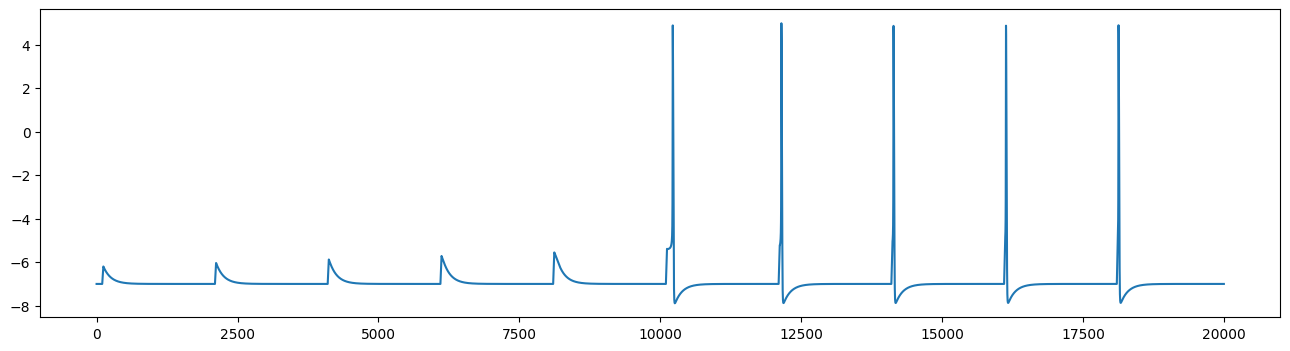

In [6]:
real_p = []
for i in range(10):
    real_p.extend(V_hh1_cpu[:,0,i,0])
plt.figure(figsize=(16,4))
plt.plot(real_p)
plt.show()

plt.figure(figsize=(16, 4))
plt.rcParams["font.size"] = 18
plt.plot(V_hh1_cpu[:,0,:,0])
#plt.legend()
plt.show()

data_list = [
    (V_hh2_cpu[:, 0, 0], "V_hh2[:, 0, 0]"),
    (V_hh2_cpu[:, 0, 1, 0], "V_hh2[:, 0, 1, 0]"),
    (V_hh2_cpu[:, 0, 2, 0], "V_hh2[:, 0, 2, 0]"),
    (V_hh2_cpu[:, 0, 3, 0], "V_hh2[:, 0, 3, 0]"),
    (V_hh2_cpu[:, 0, 4, 0], "V_hh2[:, 0, 4, 0]")
]

# 循环绘制图像
for data, label in data_list:
    plt.figure(figsize=(16, 4))
    plt.plot(data, label=label)
    # plt.legend()  # 如果需要图例，取消注释
    plt.show()

In [5]:
@torch.jit.script
def euler_2v_gpu_scripted(
        V: torch.Tensor,
        N: torch.Tensor,
        P: torch.Tensor,
        I_true: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:
    # 将 I_true 扩展最后一个维度: (T, protocols, 1)
    I_true = I_true.unsqueeze(-1)

    # 从 P 中提取参数，每个参数 reshape 为 (1, num_particles)
    a_fn, a_fp, b_fn, c_fn, a_gn, a_gp, b_gn, c_gn, r_g, phi, tau, k = [
        P[:, i].view(1, -1) for i in range(P.shape[1])
    ]

    dt: float = 0.00005

    b_fp = a_fn * b_fn / a_fp
    c_fp = a_fn * b_fn * b_fn + c_fn - a_fp * b_fp * b_fp
    b_gp = r_g - a_gn * (r_g - b_gn) / a_gp
    c_gp = a_gn * (r_g - b_gn) * (r_g - b_gn) - a_gp * (r_g - b_gp) * (r_g - b_gp) + c_gn

    active_mask = torch.ones((V.size(1), V.size(2)), dtype=torch.bool, device=V.device)
    T = V.size(0)

    for t in range(T - 1):
        v = V[t]
        n = N[t]
        I_stim = I_true[t] * k * 10.0

        fv = torch.where(v < 0.0, a_fn * (v - b_fn) * (v - b_fn) + c_fn,
                         a_fp * (v - b_fp) * (v - b_fp) + c_fp)
        gv = torch.where(v < r_g, a_gn * (v - b_gn) * (v - b_gn) + c_gn,
                         a_gp * (v - b_gp) * (v - b_gp) + c_gp)

        dv = phi * (fv - n + 0. + I_stim) / tau * dt
        dn = (gv - n) / tau * dt

        new_v = torch.where(active_mask, v + dv, v)
        new_n = torch.where(active_mask, n + dn, n)

        V[t + 1] = new_v
        N[t + 1] = new_n

        exceeded_mask = (new_v.abs() >= 200.0) | (new_n.abs() >= 200.0)
        active_mask = active_mask & (~exceeded_mask)

    return V, N


def objective(params_batch):
    # 在积分和状态更新中使用 AMP 混合精度加速
    with torch.amp.autocast('cuda'):
        V_zero = torch.zeros((20000, 1, num_neurons), device='cuda', dtype=torch.float32)
        N_zero = torch.zeros((20000, 1, num_neurons), device='cuda', dtype=torch.float32)
        V_init_1 = torch.zeros((2000, 10, num_neurons), device='cuda', dtype=torch.float32)
        N_init_1 = torch.zeros((2000, 10, num_neurons), device='cuda', dtype=torch.float32)
        V_init_2 = torch.zeros((time_steps, 5, num_neurons), device='cuda', dtype=torch.float32)
        N_init_2 = torch.zeros((time_steps, 5, num_neurons), device='cuda', dtype=torch.float32)

        V_zero_out, N_zero_out = euler_2v_gpu_scripted(V_zero, N_zero, params_batch, I_true_zero)
        V_init_1[0] = V_zero_out[-1, 0, :].unsqueeze(0).repeat(10, 1)
        N_init_1[0] = N_zero_out[-1, 0, :].unsqueeze(0).repeat(10, 1)
        V_init_2[0] = V_zero_out[-1, 0, :].unsqueeze(0).repeat(5, 1)
        N_init_2[0] = N_zero_out[-1, 0, :].unsqueeze(0).repeat(5, 1)

        V_short, _ = euler_2v_gpu_scripted(V_init_1, N_init_1, params_batch, I_hh1)
        V_long, _ = euler_2v_gpu_scripted(V_init_2, N_init_2, params_batch, I_hh2)

        short_results = spike_detect(V_short)
        fit_results = spike_detect(V_long)

    neuron_errors = {}
    error_time2 = 0
    error_amp2 = 0
    error_num2 = 0
    error_reset2 = 0
    error_width2 = 0
    error_time1 = 0
    error_amp1 = 0
    error_width1 = 0
    for protocol, neuron_data_per_protocol in neuron_data_2.items():
        reference = neuron_data_per_protocol[0]
        fit_data_per_protocol = fit_results[protocol]
        for neuron_idx, fit_data in fit_data_per_protocol.items():
            if reference["spike_num"] == 0:
                protocol_error = fit_data["spike_num"]
            else:
                error_time = error_func(reference["spike_time"], fit_data["spike_time"])
                error_amp = error_func(reference["spike_amp"], fit_data["spike_amp"])
                error_num = torch.tensor(abs((reference["spike_num"] - fit_data["spike_num"]) / reference["spike_num"]),
                                         dtype=torch.float32, device="cuda")
                error_reset = error_func(reference["spike_reset"], fit_data["spike_reset"])
                error_width = error_func(reference["width"], fit_data["width"])
                error_time2 += error_time
                error_amp2 += error_amp
                error_num2 += error_num
                error_reset2 += error_reset
                error_width2 += error_width
                protocol_error = (error_time + error_width + error_num) * 0.9 + (error_amp + error_reset) * 0.1
            if neuron_idx not in neuron_errors:
                neuron_errors[neuron_idx] = protocol_error
            else:
                neuron_errors[neuron_idx] += protocol_error
    print('time2 = ', error_time2 / 37)
    print('amp2 = ', error_amp2 / 37)
    print('num2 = ', error_num2/ 37)
    print('reset2 = ', error_reset2/ 37)
    print('width2 = ', error_width2/ 37)
    for protocol, neuron_data_per_protocol in neuron_data_1.items():
        reference = neuron_data_per_protocol[0]
        fit_data_per_protocol = short_results[protocol]
        for neuron_idx, fit_data in fit_data_per_protocol.items():
            protocol_error = 0
            if reference["spike_num"] == 0:
                if fit_data["spike_num"] > 0:
                    protocol_error = protocol_error + 5 - protocol
                    print(f'pulse not correct at {protocol}')
            else:
                if fit_data["spike_num"] == 0:
                    protocol_error = protocol_error + protocol - 4
                    print(f'pulse not correct at {protocol}')
                else:
                    error_time = error_func(reference["spike_time"], fit_data["spike_time"])
                    error_amp = error_func(reference["spike_amp"], fit_data["spike_amp"])
                    error_width = error_func(reference["width"], fit_data["width"])
                    protocol_error += (error_time + error_width) * 0.9 + error_amp * 0.1
                    error_time1 += error_time
                    error_amp1 += error_amp
                    error_width1 += error_width
            if neuron_idx not in neuron_errors:
                neuron_errors[neuron_idx] = protocol_error
            else:
                neuron_errors[neuron_idx] += protocol_error
    print('time1 = ', error_time1/5 )
    print('amp1 = ', error_amp1/5)
    print('width1 = ', error_width1/5)
    var_last_1000 = V_zero_out[-1000:, 0, :].var(dim=0)
    delta = (V_zero_out[-1, 0, :] - V_zero_out[-500, 0, :]).abs()
    spike_count = spike_num_detect(V_zero_out)
    for neuron_idx in neuron_errors.keys():
        if var_last_1000[neuron_idx] > 1:
            neuron_errors[neuron_idx] = torch.tensor(float('inf'), device='cuda')
            print('var_last_1000 > 1')
        if delta[neuron_idx] > 1e-4:
            neuron_errors[neuron_idx] = torch.tensor(float('inf'), device='cuda')
            print('delta > 1e-4')
        if spike_count[0][neuron_idx] >= 2:
            neuron_errors[neuron_idx] = torch.tensor(float('inf'), device='cuda')
            print('spike_count >= 2')
    error_all = torch.stack([neuron_errors[neuron_idx] for neuron_idx in sorted(neuron_errors.keys())])
    return error_all,V_long,V_short


def error_func(true, test):
    if test == []:
        errors = float('inf')
    else:
        true = np.array(true)
        test = np.array(test)
        true_length = len(true)
        test_length = len(test)
        min_len = min(true_length, test_length)
        truncated_true = true[:min_len]
        truncated_test = test[:min_len]
        err = np.sum(np.abs((truncated_true - truncated_test) / truncated_true))
        length_penalty = abs(test_length - true_length)
        err += length_penalty
        errors = err
    return errors


In [6]:
# a_fn, a_fp, b_fn, c_fn,  a_gn, a_gp, b_gn, c_gn,  r_g, phi, tau, k
# a_fn, a_fp, b_fn, c_fn, a_gn, a_gp, b_gn, c_gn, r_g, phi, tau
P_init = torch.tensor([1.9038115e+00,-2.3646886e+00,-4.9998689e+00,-2.8084641e+00,
  1.5523790e+00, 1.2404639e+01,-4.9999475e+00,-2.3729553e+00,
  3.3359766e+00, 1.0000000e-01, 1.9313709e-04, 2.9370816e+00], device='cuda', dtype=torch.float32)
P_init = P_init.unsqueeze(0)
error,vlong,vshort = objective(P_init)
error

time2 =  0.0030751234251741115
amp2 =  0.016800141465034654
num2 =  tensor(0., device='cuda:0')
reset2 =  0.005755297901832266
width2 =  0.0
time1 =  0.05277640612764902
amp1 =  0.02442264454835159
width1 =  0.0


tensor([0.4356], device='cuda:0')

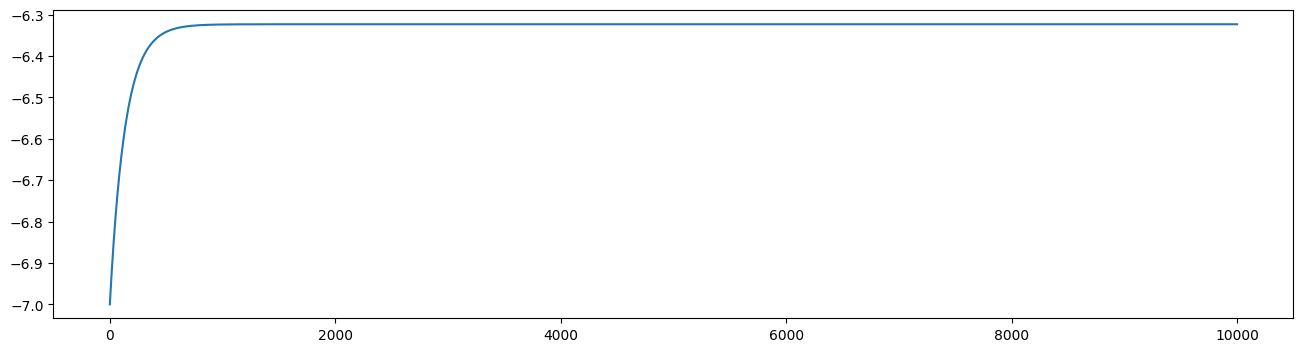

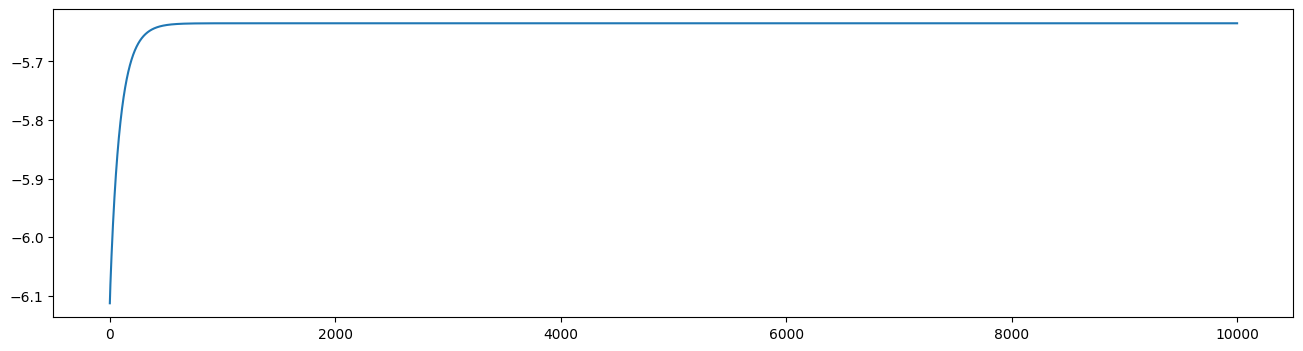

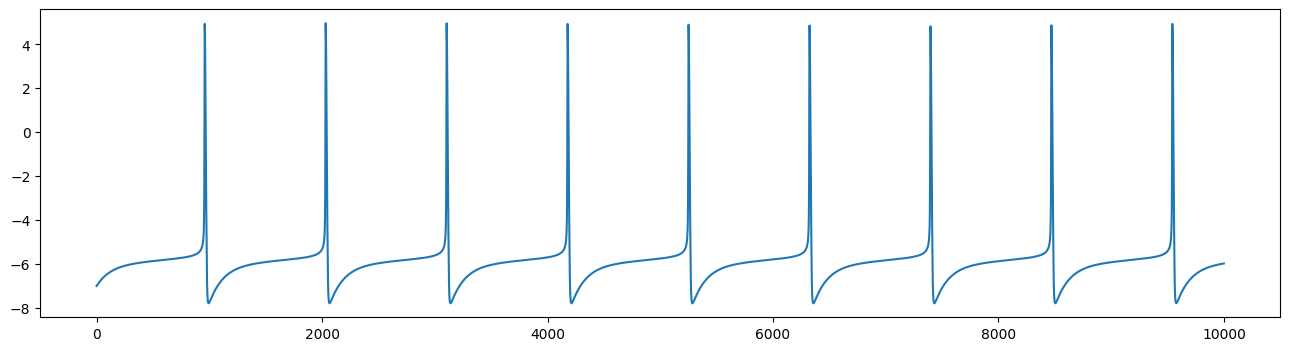

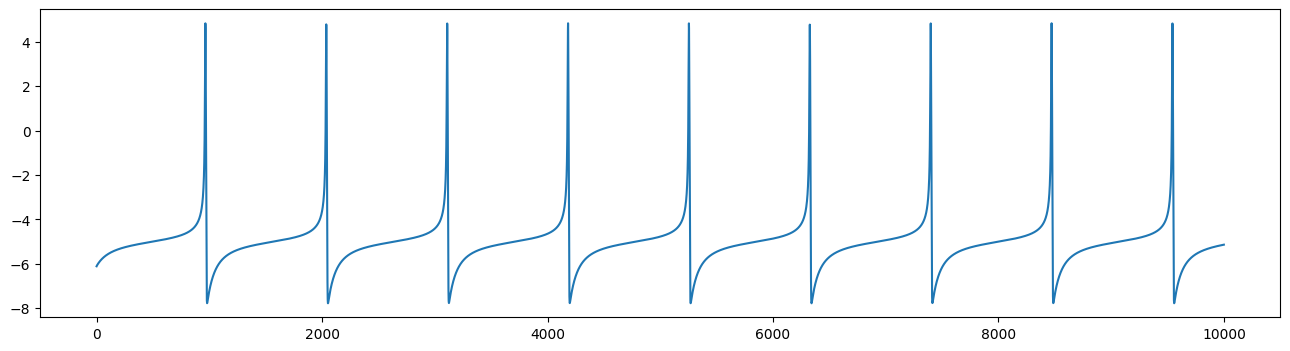

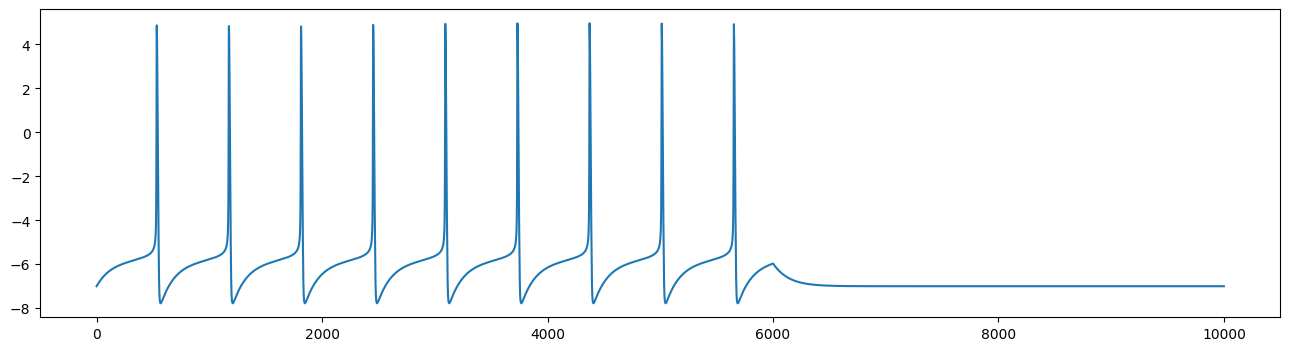

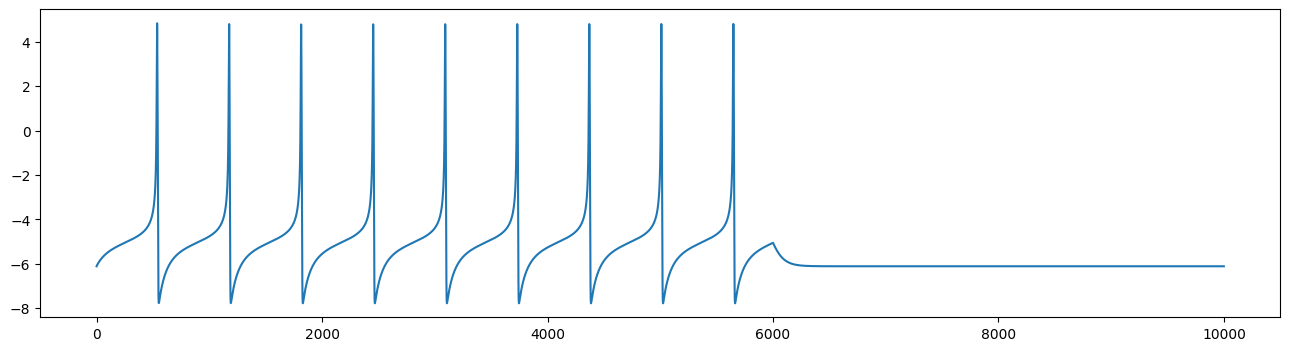

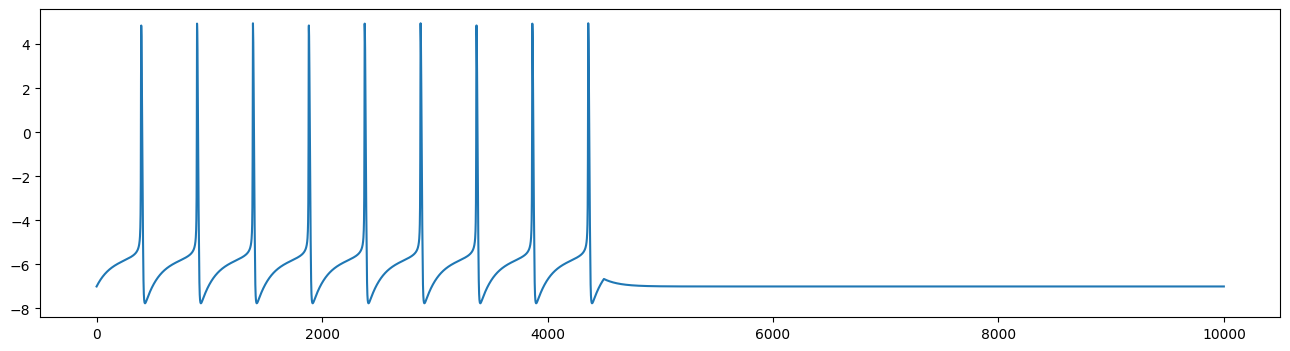

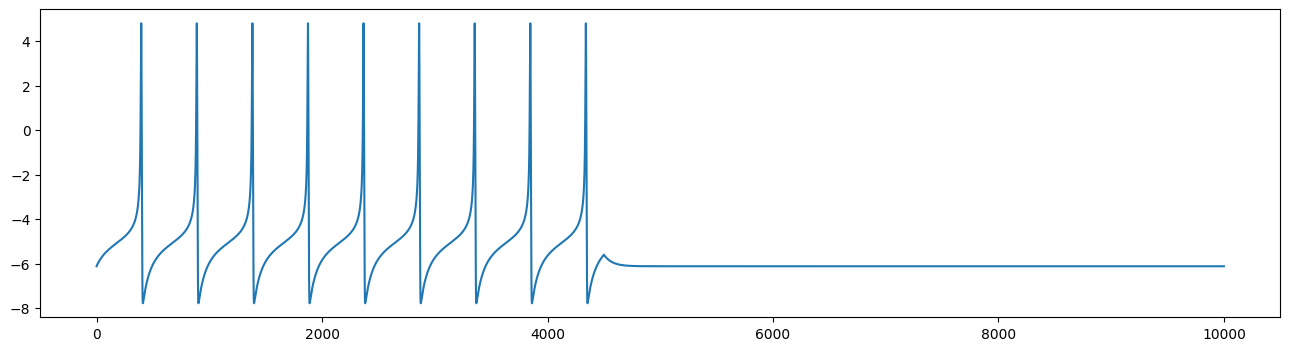

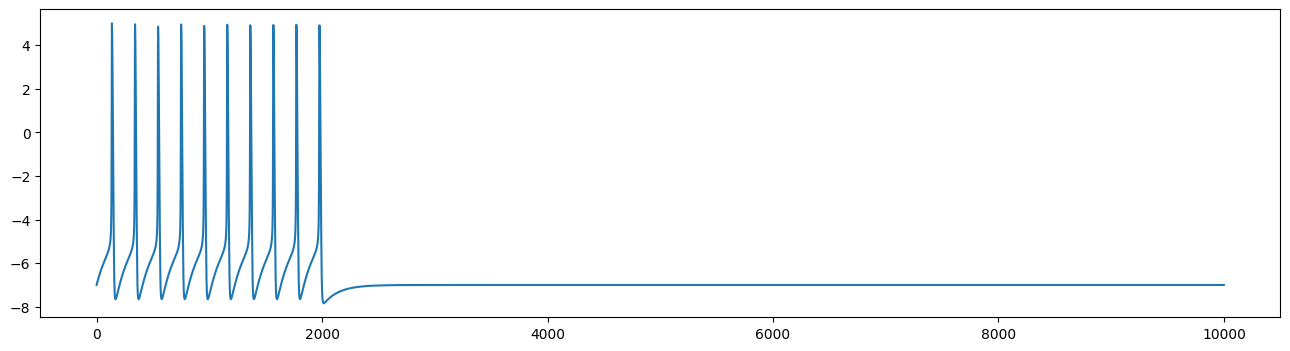

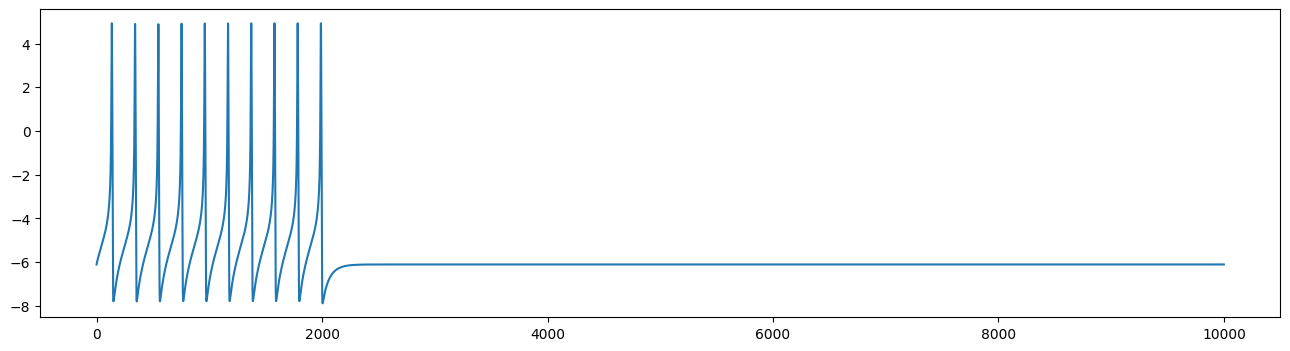

In [7]:
fit_res2 = vlong.cpu()
fit_res1 = vshort.cpu()
data_list = [
    (V_hh2_cpu[:, 0, 0]),
    (fit_res2[:, 0, 0]),
    (V_hh2_cpu[:, 0, 1, 0]),
    (fit_res2[:, 1, 0]),
    (V_hh2_cpu[:, 0, 2, 0]),
    (fit_res2[:, 2, 0]),
    (V_hh2_cpu[:, 0, 3, 0]),
    (fit_res2[:, 3, 0]),
    (V_hh2_cpu[:, 0, 4, 0]),
    (fit_res2[:, 4, 0])
]

# 循环绘制图像
for data in data_list:
    plt.figure(figsize=(16, 4))
    plt.plot(data)
    # plt.legend()  # 如果需要图例，取消注释
    plt.show()

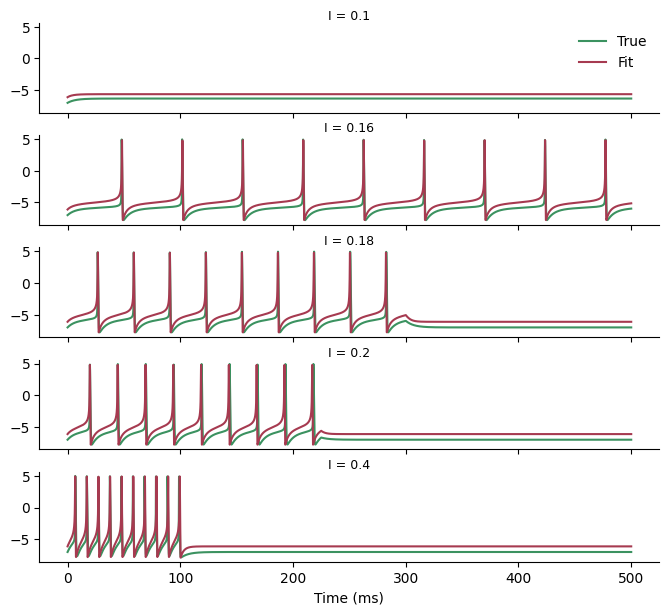

In [9]:
plt.figure(figsize=(8, 7))
T = np.linspace(0, 500, 10000)

# ===== 1. 计算统一 y 轴范围 =====
all_hh = V_hh2_cpu[:, 0, :, 0].reshape(-1)
all_fit = fit_res2.reshape(-1)

y_min = min(all_hh.min(), all_fit.min())
y_max = max(all_hh.max(), all_fit.max())

# 美观处理：加一点 padding，避免曲线贴边
y_pad = 0.05 * (y_max - y_min)
y_min -= y_pad
y_max += y_pad

stimuli = ()
# ===== 2. 绘图 =====
for i in range(5):
    ax = plt.subplot(5, 1, i + 1)

    ax.plot(T, V_hh2_cpu[:, 0, i, 0], color='#3B9260', label='True')
    ax.plot(T, fit_res2[:, i, 0], color='#A63A50', label='Fit')

    # ---- 设置统一 y 轴刻度 ----
    ax.set_ylim(y_min, y_max)

    # 去掉不必要边框
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)




    # 只展示第一幅图的 legend
    if i == 0:
        ax.legend(loc='upper right', frameon=False)
        ax.set_title(f"I = 0.1", fontsize=9, pad=-5)
    elif i ==1:
        ax.set_title(f"I = 0.16", fontsize=9, pad=-5)
    elif i ==2:
        ax.set_title(f"I = 0.18", fontsize=9, pad=-5)
    elif i ==3:
        ax.set_title(f"I = 0.2", fontsize=9, pad=-5)
    elif i ==4:
        ax.set_title(f"I = 0.4", fontsize=9, pad=-5)

    # 隐藏前 4 行 x 轴刻度
    if i < 4:
        ax.tick_params(axis='x', which='both', labelbottom=False)
    else:
        ax.set_xlabel("Time (ms)")

    ax.tick_params(axis='y', pad=3)

plt.subplots_adjust(hspace=0.25)
plt.show()


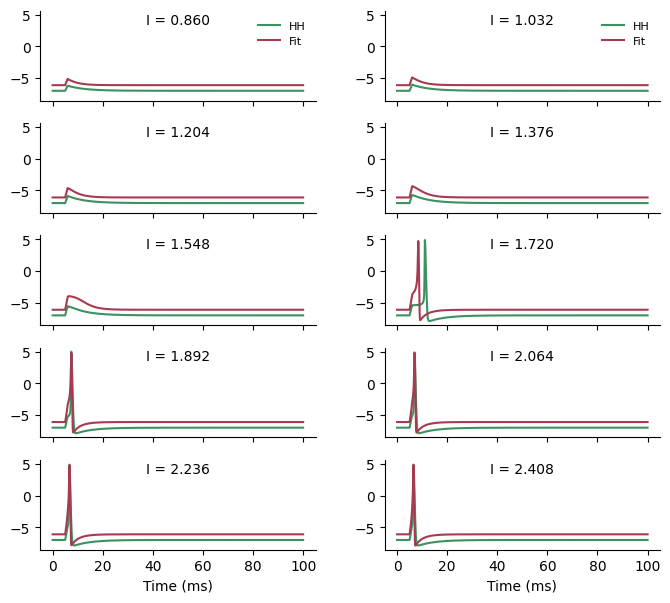

In [10]:
T_p = np.linspace(0,100,2000)
num_groups = V_hh1.shape[2]   # 通常为10组
rows, cols = 5, 2

# ==== 1. 计算全局的y轴范围（HH + Fit）====
all_hh = V_hh1_cpu[:, 0, :, 0].reshape(-1)
all_fit = fit_res1.reshape(-1)

y_min = min(all_hh.min(), all_fit.min())
y_max = max(all_hh.max(), all_fit.max())

# 可选：稍微加一点余量使图更美观
y_pad = 0.05 * (y_max - y_min)
y_min -= y_pad
y_max += y_pad

# ==== 2. 绘图 ====
plt.figure(figsize=(8, 7))

for i in range(num_groups):
    ax = plt.subplot(rows, cols, i+1)

    hh_i = V_hh1_cpu[:, 0, i, 0]
    fit_i = fit_res1[:, i, 0]

    ax.plot(T_p,hh_i, color='#3B9260', label='HH')
    ax.plot(T_p,fit_i, color='#A63A50', label='Fit')

    # 统一 y 轴刻度
    ax.set_ylim(y_min, y_max)

    # 去除上、右边框
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # 标题
    # ax.set_title(f"I = {0.86 + i * 0.172:.3f}", fontsize=9, pad=-5)
    ax.text(0.5, 0.9, f"I = {0.86 + i * 0.172:.3f}",
        transform=ax.transAxes,
        ha='center', va='center')

    # 隐藏前几行 x 轴刻度
    if i < (rows - 1) * cols:
        ax.tick_params(axis='x', labelbottom=False)
    else:
        ax.set_xlabel("Time (ms)")  # 最后一行添加 x 轴标签（可自定义）

    if i < 2:
        ax.legend(loc='upper right', frameon=False, fontsize=8)

plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()


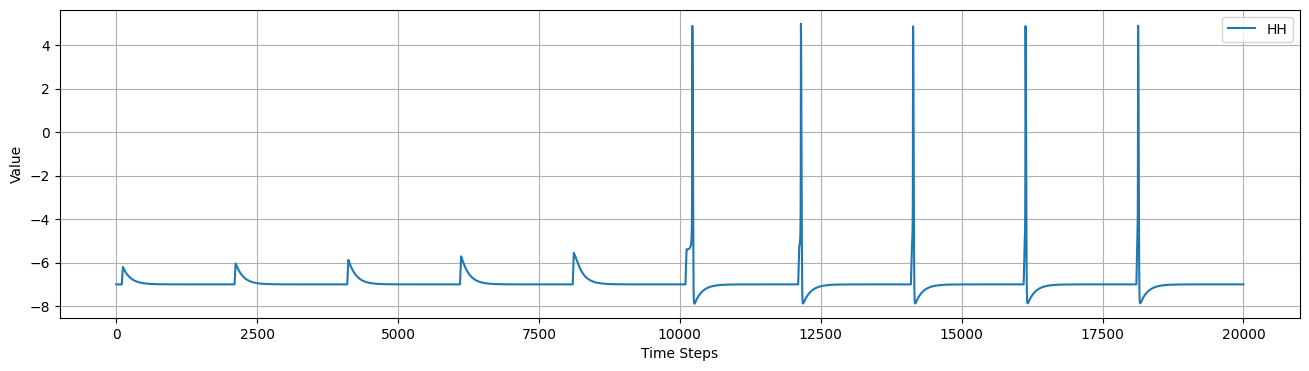

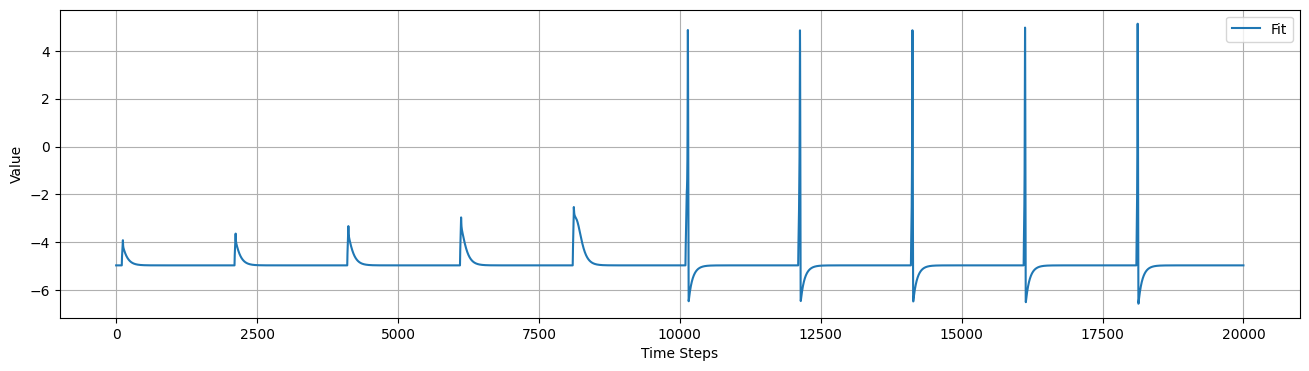

In [9]:
hh_short_data = []
fit_short_data = []

# 将 V_hh1[:, 0, i, 0] 按顺序拼接在一起
for i in range(V_hh1.shape[2]):  # 遍历第3维的索引
    hh_short_data.extend(V_hh1_cpu[:, 0, i, 0])

for i in range(fit_res1.shape[1]):  # 遍历第3维的索引
    fit_short_data.extend(fit_res1[:, i, 0])

# 转换为 NumPy 数组
hh_short_data = np.array(hh_short_data)
fit_short_data = np.array(fit_short_data)
# 绘制拼接后的数据
plt.figure(figsize=(16, 4))
plt.plot(hh_short_data, label="HH")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(fit_short_data, label="Fit")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

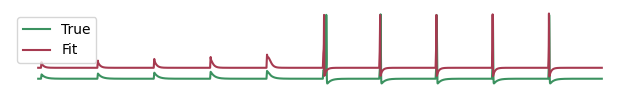

In [10]:
plt.figure(figsize=(8, 1))
plt.plot(hh_short_data, color = '#3B9260',label='True')

plt.plot(fit_short_data, color = '#A63A50',label='Fit')
# 移除坐标轴
plt.axis('off')

# 移除边框
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.legend()
plt.show()

In [31]:
I_hh1_cpu = I_hh1.cpu()

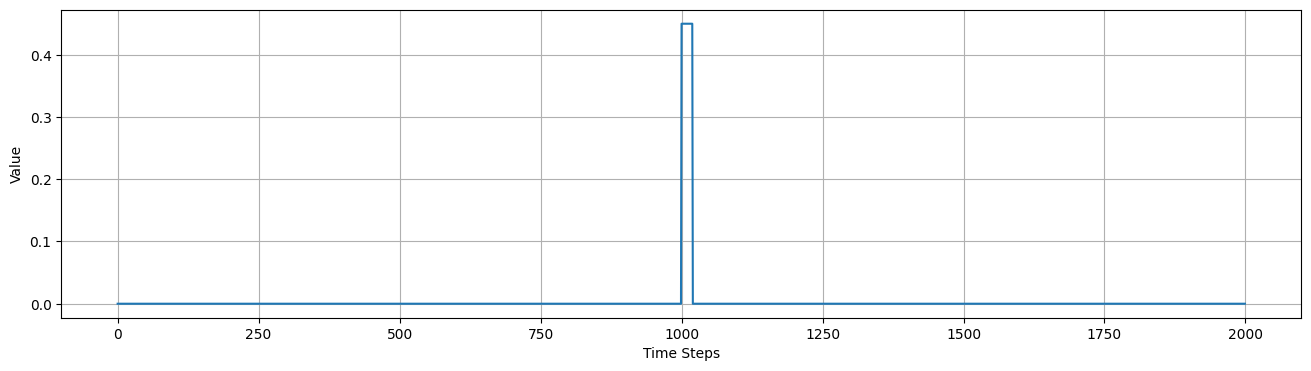

In [34]:
plt.figure(figsize=(16, 4))
plt.plot(I_hh1_cpu[:,4])

plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.grid()
plt.show()

In [16]:
spike_detect(fit_res1)

{0: {0: {'spike_time': [],
   'spike_amp': [],
   'spike_num': 0,
   'spike_reset': [],
   'width': []}},
 1: {0: {'spike_time': [],
   'spike_amp': [],
   'spike_num': 0,
   'spike_reset': [],
   'width': []}},
 2: {0: {'spike_time': [],
   'spike_amp': [],
   'spike_num': 0,
   'spike_reset': [],
   'width': []}},
 3: {0: {'spike_time': [],
   'spike_amp': [],
   'spike_num': 0,
   'spike_reset': [],
   'width': []}},
 4: {0: {'spike_time': [],
   'spike_amp': [],
   'spike_num': 0,
   'spike_reset': [],
   'width': [18]}},
 5: {0: {'spike_time': [0.05089999735355377],
   'spike_amp': [6.54860258102417],
   'spike_num': 1,
   'spike_reset': [-5.383827209472656],
   'width': [9]}},
 6: {0: {'spike_time': [0.05069999769330025],
   'spike_amp': [6.763090133666992],
   'spike_num': 1,
   'spike_reset': [-5.8729424476623535],
   'width': [12]}},
 7: {0: {'spike_time': [0.050599999725818634],
   'spike_amp': [6.947635173797607],
   'spike_num': 1,
   'spike_reset': [-6.108835697174072],
  

In [ ]:
def spike_num_detect(V_init):
    Vt = V_init[:, :, :]
    thresholds = compute_thresholds(Vt)
    peaks = detect_peaks_scripted(Vt, thresholds)
    (peak_times_idx, peak_protocols_idx, peak_neurons_idx), peak_values = map_events(Vt, peaks)
    _, num_protocols, num_neurons = Vt.shape
    pn_pairs = torch.stack((peak_protocols_idx, peak_neurons_idx), dim=1)
    unique_pairs, inverse_indices, counts = torch.unique(pn_pairs, dim=0, return_inverse=True, return_counts=True)
    spike_counts = torch.zeros((num_protocols, num_neurons), dtype=torch.int64, device='cuda')
    spike_counts[unique_pairs[:, 0], unique_pairs[:, 1]] = counts
    return spike_counts

In [42]:
Vt_test = fit_res1[:, 3:5, :]
thre_test = compute_thresholds(Vt_test)
print(thre_test)

tensor([[0.5000],
        [1.0994]])


In [36]:
import sys

torch.set_printoptions(threshold=np.inf)

In [43]:
peaks_test = detect_peaks_scripted(Vt_test, thre_test)
print(peaks_test[:,1])

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False

In [44]:
(peak_times_idx, peak_protocols_idx, peak_neurons_idx), peak_values = map_events(Vt_test, peaks_test)

In [45]:
peak_values

tensor([4.1624])

In [40]:
print(fit_res1[1000:1100, 4, :])

tensor([[-5.0267],
        [-3.9610],
        [-3.6044],
        [-3.3901],
        [-3.2260],
        [-3.0805],
        [-2.9398],
        [-2.7968],
        [-2.6469],
        [-2.4865],
        [-2.3120],
        [-2.1190],
        [-1.9019],
        [-1.6529],
        [-1.3602],
        [-1.0054],
        [-0.5579],
        [ 0.0369],
        [ 0.8853],
        [ 2.0655],
        [ 3.4935],
        [ 3.8310],
        [ 4.0559],
        [ 4.1624],
        [ 4.1624],
        [ 4.0771],
        [ 3.9292],
        [ 3.7382],
        [ 3.5190],
        [ 3.2818],
        [ 3.0327],
        [ 2.7753],
        [ 2.5111],
        [ 2.2396],
        [ 1.9590],
        [ 1.6651],
        [ 1.3512],
        [ 1.0064],
        [ 0.6134],
        [ 0.1437],
        [-0.4523],
        [-1.2255],
        [-2.1172],
        [-2.9739],
        [-3.6202],
        [-3.9918],
        [-4.1604],
        [-4.2262],
        [-4.2502],
        [-4.2589],
        [-4.2623],
        [-4.2638],
        [-4.